In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def load_data_label(feature_path, label_file_path, feature_name = [], num_instance = 2000 ):
    y = pd.read_csv(label_file_path, header=0)[feature_name]
    # Load the data from each file and concatenate into a single feature matrix
    feature_matrix = None
    label_matrix = y[:num_instance]

    for i in range(1, num_instance + 1):
        file_path = os.path.join(feature_path, str(i) + ".mp3.npy")
        # print("Processed file " + file_path)
        data = np.load(file_path)
        data = [np.expand_dims(data, axis=-1)]
        if feature_matrix is None:
            feature_matrix = data
        else:
            feature_matrix = np.concatenate((feature_matrix, data), axis=0)
    return feature_matrix, label_matrix


In [3]:
def load_data_label(feature_path, label_file_path):
    label_matrix = pd.read_excel(label_file_path, header=0).drop(['Number','TARGET'],axis=1)
    # Load the data from each file and concatenate into a single feature matrix
    feature_matrix = None

    for i in range(1, len(label_matrix) + 1):
        if i < 10:
          i = '00' + str(i)
        elif i < 100:
          i = '0' + str(i)

        file_path = os.path.join(feature_path, str(i) + ".mp3.npy")
        # print("Processed file " + file_path)
        data = np.load(file_path)
        data = [np.expand_dims(data, axis=-1)]
        if feature_matrix is None:
            feature_matrix = data
        else:
            feature_matrix = np.concatenate((feature_matrix, data), axis=0)
    return feature_matrix, label_matrix


In [4]:
## File parameter
FOLDER_PATH = '/content/drive/MyDrive/music-retrival'
TRAIN_DATA = FOLDER_PATH+ "/data-emotion/set1/spectograms_313x149_Mel_func/"
LABEL_DATA = FOLDER_PATH + "/data-emotion/set1/mean_ratings_set1.xls"

TEST_DATA = FOLDER_PATH+ "/data-emotion/set2/spectograms_313x149_Mel_func/"
EVAL_DATA = FOLDER_PATH + "/data-emotion/set2/mean_ratings_set2.xls"

MODEL_PATH = FOLDER_PATH + '/model/mid2e/'
## DATA PARAMETER
NUM_INSTANCE = 360
TEST_SIZE = 0.2

## Model Parameter
BATCH_SIZE = 8
EPOCHS = 40
MODEL_SAVE = True

In [5]:
 # load feature, label
feature_matrix, label_matrix = load_data_label(TRAIN_DATA, LABEL_DATA)

# feature_matrix = pd.DataFrame(feature_matrix)
# split train, test
train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix, label_matrix, test_size=TEST_SIZE, random_state=42)

In [6]:
def relu_with_min(output):
    return tf.keras.backend.maximum(output, 1)

In [7]:
def model_middle_feature_construction():
    model = keras.Sequential([
    # 1st Layer
    layers.Conv2D(64, kernel_size=(5, 5), strides = 2 ,activation='relu', padding="valid",input_shape=feature_matrix.shape[1:]),
    layers.BatchNormalization(),
    # 2nd Layer
    layers.Conv2D(64, kernel_size=(3, 3), strides = 1 ,activation='relu', padding="same"),
    layers.BatchNormalization(),
    # 3rd Layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    # 4th Layer
    layers.Conv2D(128, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # 5th Layer
    layers.Conv2D(128, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # 6th Layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    # 7th
    layers.Conv2D(256, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 8th
    layers.Conv2D(256, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 9th
    layers.Conv2D(384, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 10th 
    layers.Conv2D(512, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 11th
    layers.Conv2D(256, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 12th
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256),
    layers.Dense(8, activation = relu_with_min)
])
    return model

In [8]:
model = model_middle_feature_construction()

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse',
                    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae', 'mape', 'accuracy'])

In [9]:
history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_features, test_labels))

Epoch 1/40
36/36 [==============================] - 201s 5s/step - loss: 6.7674 - root_mean_squared_error: 2.6014 - mae: 1.8767 - mape: 55.8866 - accuracy: 0.1840 - val_loss: 5.9052 - val_root_mean_squared_error: 2.4301 - val_mae: 1.7171 - val_mape: 46.4311 - val_accuracy: 0.1944
Epoch 2/40
36/36 [==============================] - 193s 5s/step - loss: 4.8317 - root_mean_squared_error: 2.1981 - mae: 1.5193 - mape: 45.9629 - accuracy: 0.2639 - val_loss: 5.0549 - val_root_mean_squared_error: 2.2483 - val_mae: 1.7567 - val_mape: 73.6139 - val_accuracy: 0.1944
Epoch 3/40
36/36 [==============================] - 195s 5s/step - loss: 4.2861 - root_mean_squared_error: 2.0703 - mae: 1.4202 - mape: 45.6810 - accuracy: 0.2812 - val_loss: 4.7152 - val_root_mean_squared_error: 2.1714 - val_mae: 1.7091 - val_mape: 81.9460 - val_accuracy: 0.0556
Epoch 4/40
36/36 [==============================] - 182s 5s/step - loss: 3.8235 - root_mean_squared_error: 1.9554 - mae: 1.3574 - mape: 43.4747 - accuracy: 0

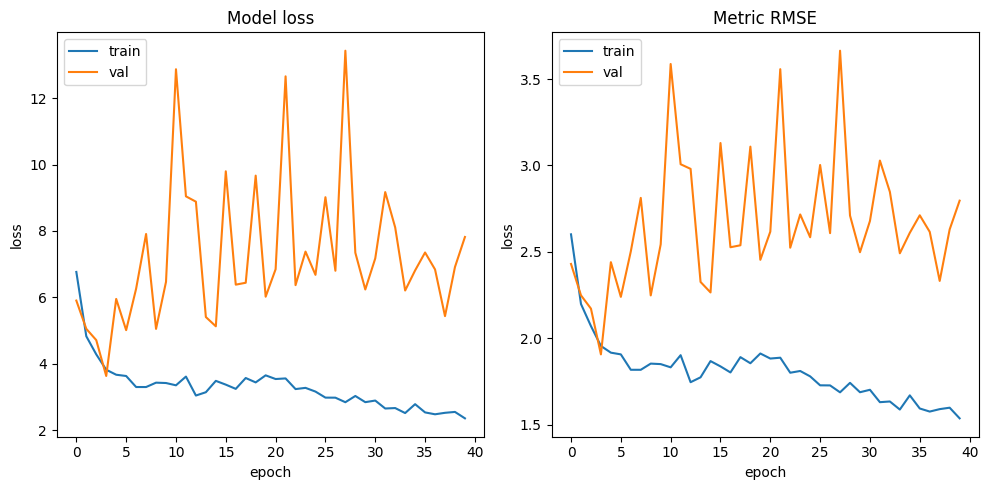

In [11]:
import matplotlib.pyplot  as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax1.set(xlabel='epoch', ylabel='loss')

ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.set_title('Metric RMSE')
# ax2.ylabel('loss')
# ax2.xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
ax2.set(xlabel='epoch', ylabel='loss')

fig.tight_layout()

In [ ]:
# if MODEL_SAVE == True:
#   model.save(MODEL_PATH+"cnn_A2E")

In [ ]:
y_pred = model.predict(test_features)
y_test = test_labels

3/3 [==============================] - 12s 3s/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)

# Compute the R-squared value
r2 = r2_score(y_test, y_pred)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print('Mean squared error: {:.2f}'.format(mse))
print('R-squared value: {:.2f}'.format(r2))
print('Mean absolute error: {:.2f}'.format(mae))

y_pred = pd.DataFrame(y_pred)
y_pred.columns = y_test.columns.values

cor_df = dict()
print('-------------------------------')
for i in y_test.columns.values:
  corr_coef = round(np.corrcoef(y_test[i], y_pred[i])[0, 1], 2)
  if 'Emotion' not in cor_df:
    cor_df['Emotion'] = [i]
    cor_df['Correlation'] = [corr_coef]
  else:
    cor_df['Emotion'] += [i]
    cor_df['Correlation'] += [corr_coef]
cor_df = pd.DataFrame(cor_df)
cor_df

Mean squared error: 5.96
R-squared value: -0.83
Mean absolute error: 1.69
-------------------------------


,Emotion,Correlation
0,valence,0.56
1,energy,0.54
2,tension,0.45
3,anger,0.69
4,fear,0.59
5,happy,0.24
6,sad,0.29
7,tender,0.23
